In [166]:
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold, StratifiedKFold, LeaveOneOut, cross_val_predict, LeaveOneGroupOut
from sklearn.metrics import accuracy_score
from sklearn.pipeline import make_pipeline
from aging.plotting import figure, format_plots

In [167]:
format_plots()

In [103]:
warnings.simplefilter('ignore')

In [138]:
df = pd.read_parquet('/n/groups/datta/win/longtogeny/data/ontogeny/version_11/longtogeny_males_raw_usage_matrix_v00.parquet')
keep_syllables = np.loadtxt('/n/groups/datta/win/longtogeny/data/ontogeny/version_11/to_keep_syllables_raw.txt', dtype=int)
df = df[keep_syllables]

In [7]:
ages = df.index.get_level_values('age')

In [128]:
bins = pd.qcut(ages, 20, labels=False)

In [129]:
df = df.set_index(pd.Index(bins // 2, name='age_bins'), append=True)

In [130]:
sample = []

for (mouse, _bin), _df in df.groupby(['mouse', bins], observed=True):
    if len(_df) > 2:
        sample.append(_df.sample(n=2, random_state=0))
    else:
        sample.append(_df)
sample = pd.concat(sample)

In [131]:
pipe = make_pipeline(
    # StandardScaler(),
    LinearSVC(dual='auto', max_iter=5000),
)

In [132]:
accs = {}
for _bin, _df in sample.groupby('age_bins', observed=True):
    _ages = np.mean(_df.index.get_level_values('age'))
    print(round(_ages, 1), len(_df))
    if len(_df) < 25:
        continue
    mouse = _df.index.get_level_values('mouse')

    try:
        preds = cross_val_predict(
            pipe,
            np.log(_df + 1e-5),
            mouse,
            cv=StratifiedKFold(n_splits=4, shuffle=True, random_state=0),
            n_jobs=-1,
        )
    except Exception:
        preds = cross_val_predict(
            pipe,
            np.log(_df + 1e-5),
            mouse,
            cv=StratifiedKFold(n_splits=2, shuffle=True, random_state=0),
            n_jobs=-1,
        )

    acc = accuracy_score(mouse, preds)
    accs[_ages] = acc

7.0 191
15.9 96
25.5 64


/home/wg41/miniconda3/envs/aging/lib/python3.10/site-packages/sklearn/svm/_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/wg41/miniconda3/envs/aging/lib/python3.10/site-packages/sklearn/svm/_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


34.5 62


/home/wg41/miniconda3/envs/aging/lib/python3.10/site-packages/sklearn/svm/_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/wg41/miniconda3/envs/aging/lib/python3.10/site-packages/sklearn/svm/_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/wg41/miniconda3/envs/aging/lib/python3.10/site-packages/sklearn/svm/_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/wg41/miniconda3/envs/aging/lib/python3.10/site-packages/sklearn/svm/_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


53.3 61
62.1 56


/home/wg41/miniconda3/envs/aging/lib/python3.10/site-packages/sklearn/svm/_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


69.9 28
119.6 27
127.7 16
138.3 5


In [133]:
s = pd.Series(accs)

<Axes: >

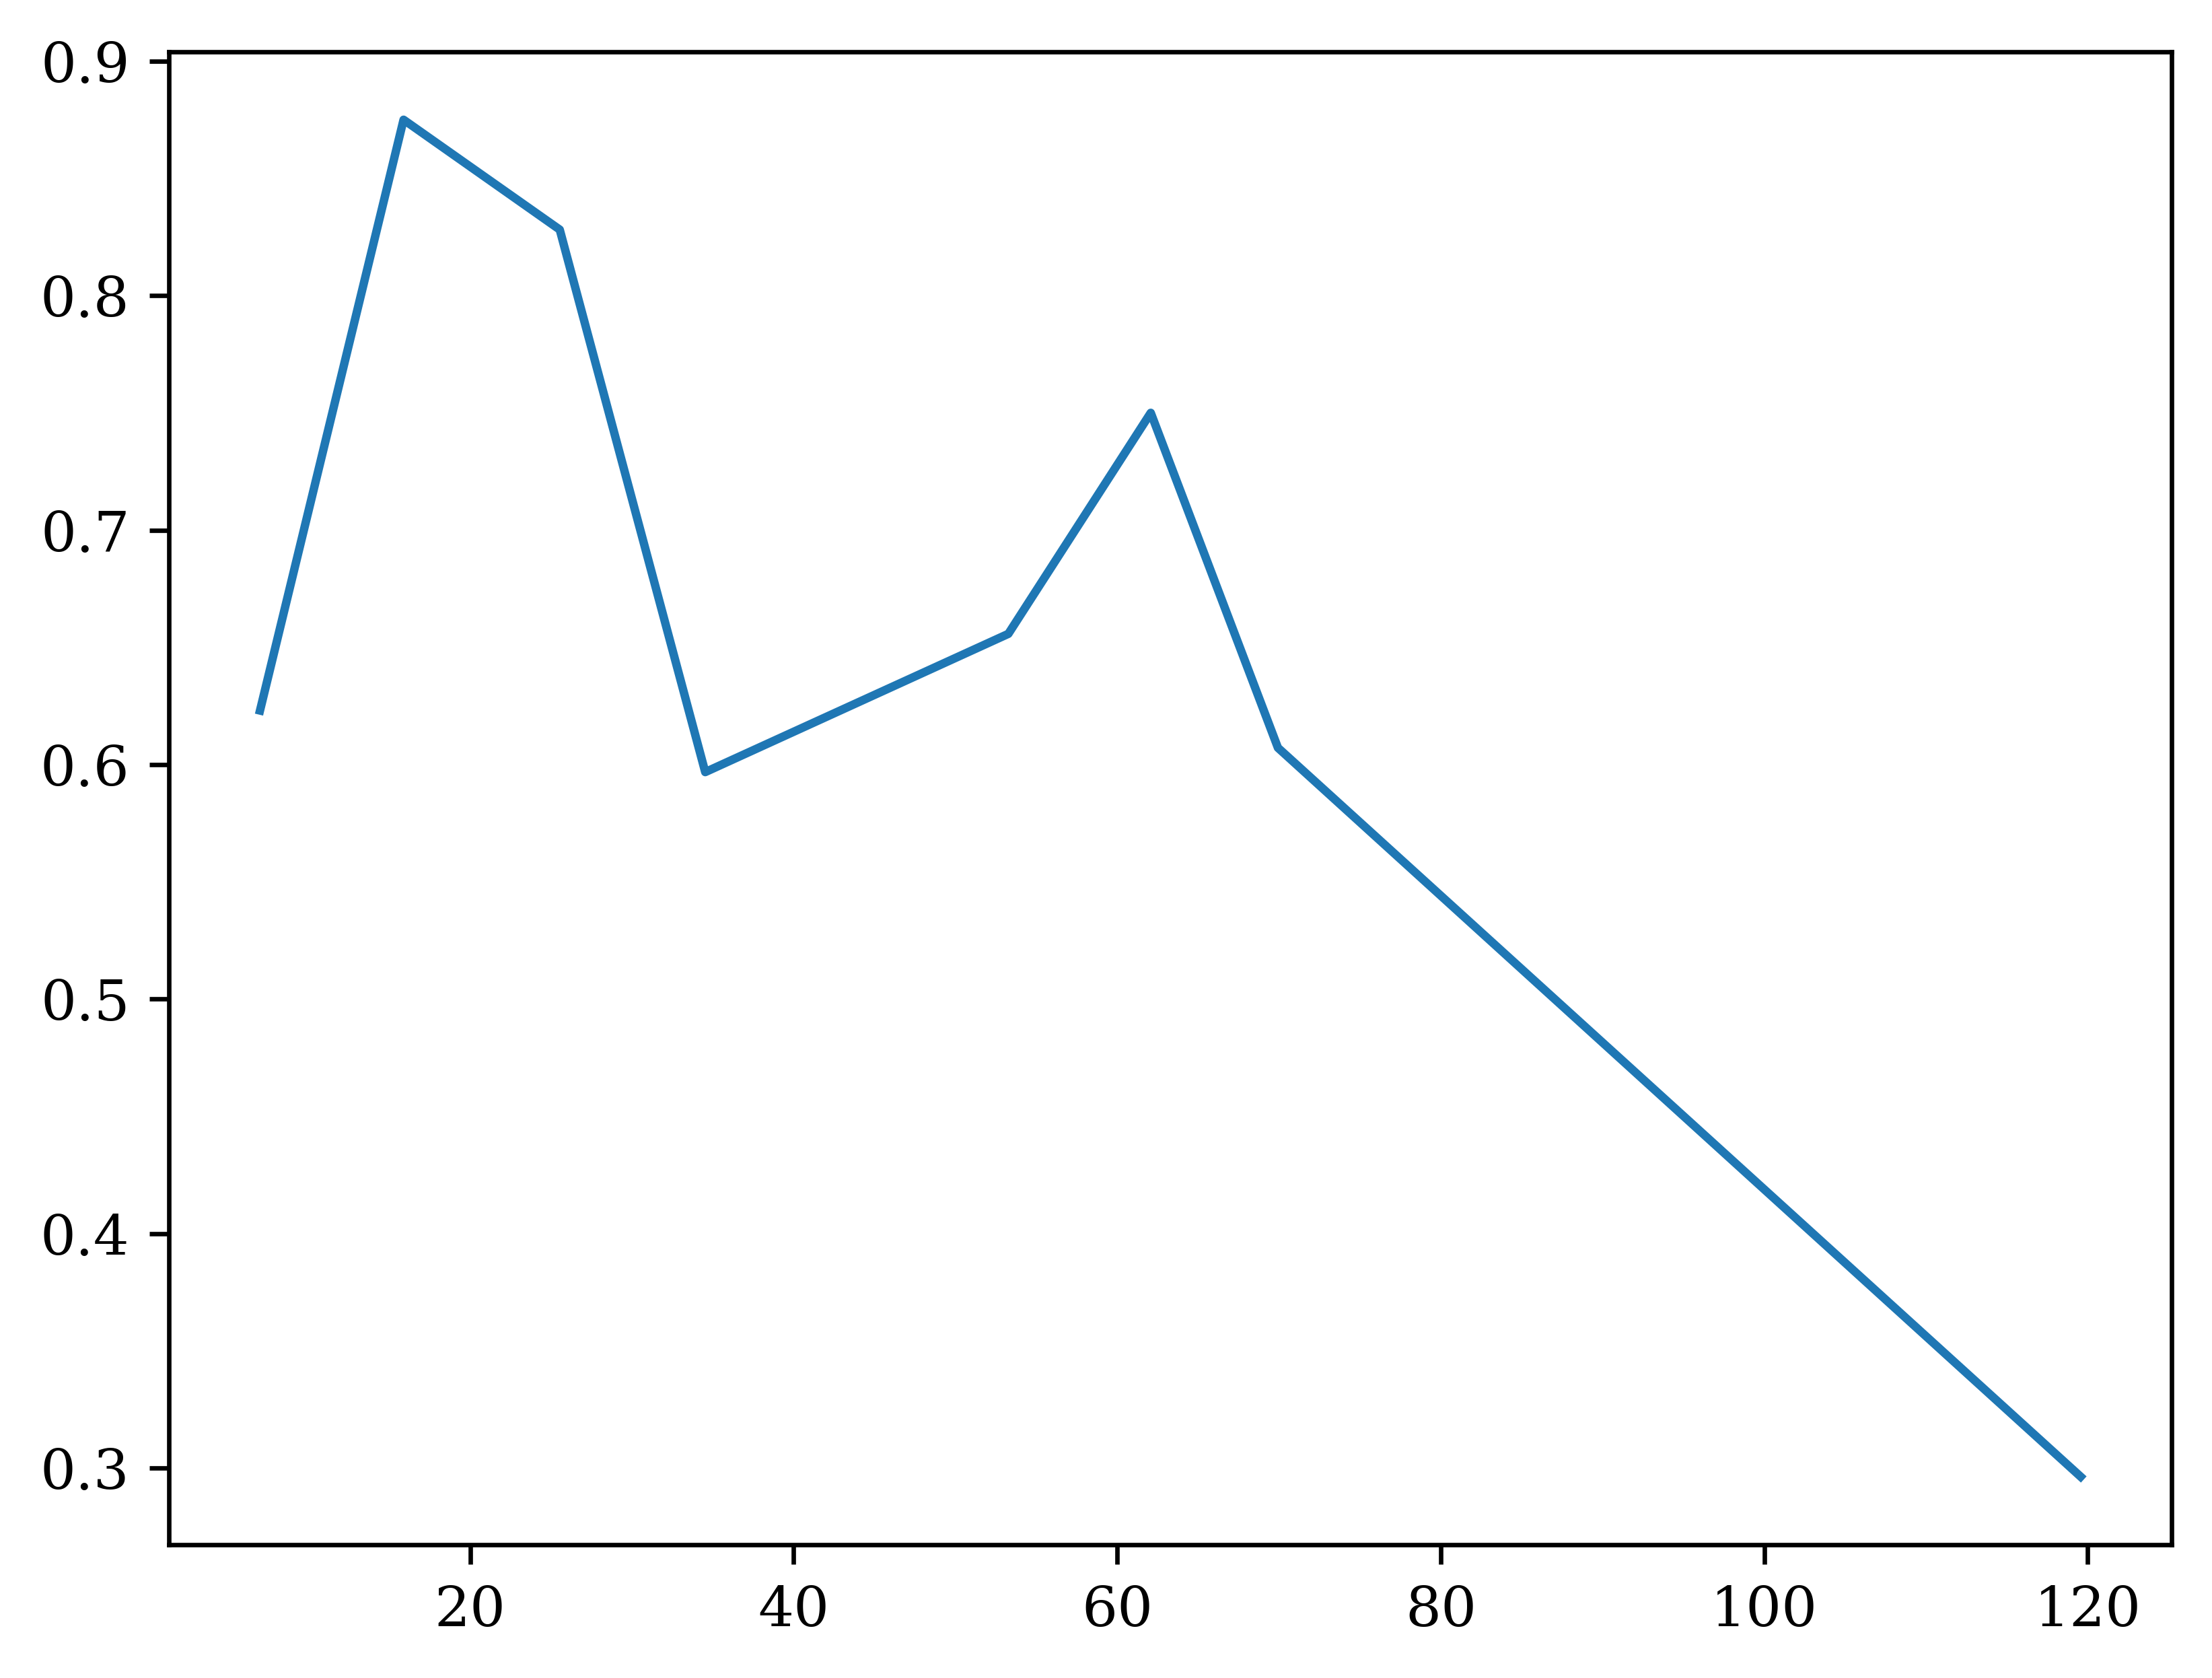

In [134]:
s.plot()

## Epoch classifier

In [139]:
young = df.query('age < 20')
middle = df.query('age > 20 & age < 50')
old = df.query('age > 50 & age < 100')

In [144]:
# looks like 6 sessions is our minimum limit

In [183]:
n_samples = 50

out = []
for i in range(n_samples):

    sample = young.groupby('mouse').sample(n=6, random_state=i)
    avg_age = np.mean(sample.index.get_level_values('age'))
    mouse = sample.index.get_level_values('mouse')

    preds = cross_val_predict(
        pipe,
        np.log(sample + 1e-5),
        mouse,
        cv=StratifiedKFold(n_splits=4, shuffle=True, random_state=i),
        n_jobs=-1,
    )

    acc = accuracy_score(mouse, preds)
    out.append(dict(acc=acc, age=avg_age, group='young'))

    sample = middle.groupby('mouse').sample(n=6, random_state=i)
    avg_age = np.mean(sample.index.get_level_values('age'))
    mouse = sample.index.get_level_values('mouse')

    preds = cross_val_predict(
        pipe,
        np.log(sample + 1e-5),
        mouse,
        cv=StratifiedKFold(n_splits=4, shuffle=True, random_state=i),
        n_jobs=-1,
    )

    acc = accuracy_score(mouse, preds)
    out.append(dict(acc=acc, age=avg_age, group='middle'))

    sample = old.groupby('mouse').sample(n=6, random_state=i)
    avg_age = np.mean(sample.index.get_level_values('age'))
    mouse = sample.index.get_level_values('mouse')

    preds = cross_val_predict(
        pipe,
        np.log(sample + 1e-5),
        mouse,
        cv=StratifiedKFold(n_splits=4, shuffle=True, random_state=i),
        n_jobs=-1,
    )

    acc = accuracy_score(mouse, preds)
    out.append(dict(acc=acc, age=avg_age, group='old'))
out = pd.DataFrame(out)

In [184]:
age_map = out.groupby('group')['age'].mean().round().astype(int)

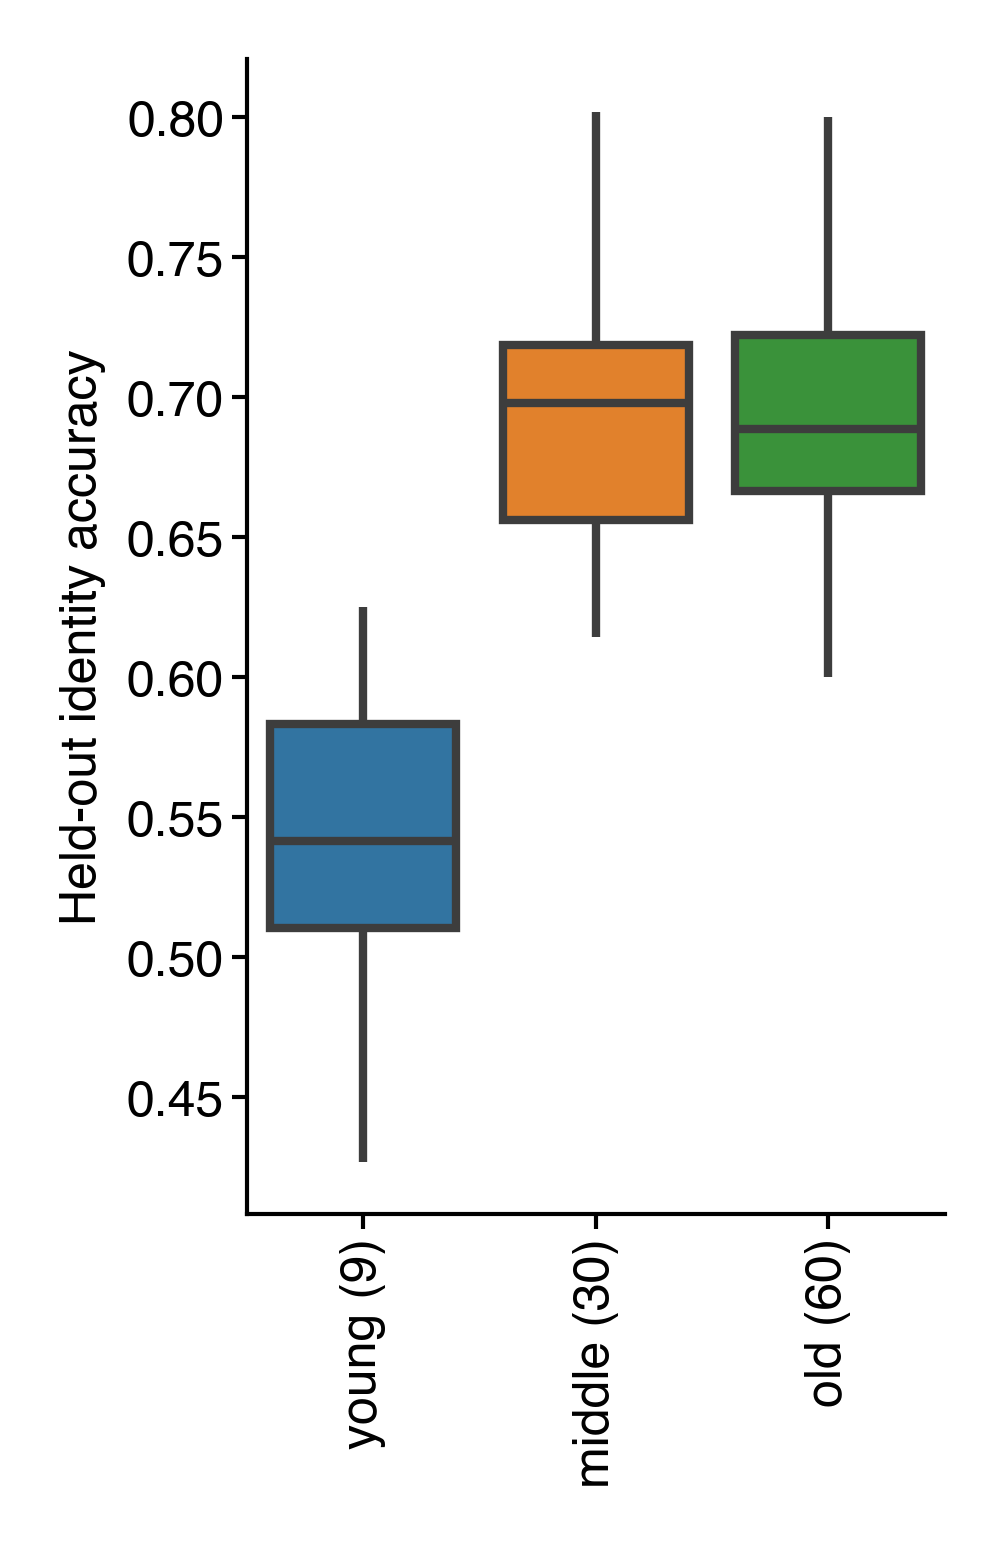

In [186]:
fig = figure(1.5, 2.5)
ax = sns.boxplot(data=out, x='group', y='acc', hue='group', showfliers=False, showcaps=False)
ticks = ax.get_xticklabels()
ax.set(xlabel='', xticklabels=[f"{l.get_text()} ({age_map[l.get_text()]})" for l in ticks], ylabel="Held-out identity accuracy")
plt.xticks(rotation=90)
sns.despine()